# Installations Required

``` py
##%pip install kagglehub
#%pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu keras-ocr numpy protobuf
#%pip cache purge
#%pip install "numpy<2" --upgrade
## Install specific versions with --no-deps to prevent auto-upgrades
#%pip install tensorflow==2.10.0
#%pip install keras-ocr==0.8.9
#%pip install tensorflow-gpu==2.10.0 --no-deps
#%pip install tensorflow-cpu==2.10.0 --no-deps
#%pip install tensorflow==2.10.0 --no-deps
#%pip install protobuf==3.20.3 --no-deps
#%pip install python-Levenshtein
#%pip install pytesseract
#%pip install easyocr
#%pip install git+https://github.com/faustomorales/keras-ocr.git@v0.8.9
#%pip install pandas
```

> **🔔 Note:** Must download Tesseract-OCR Engine to run PyTesseract: https://tesseract-ocr.github.io/tessdoc/Installation.html

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import Levenshtein
import cv2
import time
import numpy as np
import pytesseract
from PIL import Image
import keras_ocr
import easyocr
from keras.layers import Input, Lambda
from keras.models import Model
from keras.layers import Lambda
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import random

# Using GPU (if possible)

In [59]:
# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus[0])
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0]])
        b = tf.constant([[3.0], [4.0]])
        c = tf.matmul(a, b)
        print("Result:", c)
else:
    print("No GPU found, using CPU.")

# our code was run on a Nvidia GeForce RTX 4070 Super

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Result: tf.Tensor([[11.]], shape=(1, 1), dtype=float32)


In [60]:
train = pd.read_csv('1/written_name_train_v2.csv')
valid = pd.read_csv('1/written_name_validation_v2.csv')
test = pd.read_csv('1/written_name_test_v2.csv')
test

FILENAME       IDENTITY
0       TEST_0001.jpg          KEVIN
1       TEST_0002.jpg       CLOTAIRE
2       TEST_0003.jpg           LENA
3       TEST_0004.jpg          JULES
4       TEST_0005.jpg        CHERPIN
...               ...            ...
41365  TEST_41366.jpg        ALEXANE
41366  TEST_41367.jpg  PEREIRA-SILVA
41367  TEST_41368.jpg        LAURENT
41368  TEST_41369.jpg       DEFFENSE
41369  TEST_41370.jpg          MELAB

[41370 rows x 2 columns]

In [ ]:
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

#drops the values with null in identity column
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)
test.dropna(axis=0, inplace=True)

print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())
print("Number of NaNs in test set : ", test['IDENTITY'].isnull().sum())

Number of NaNs in train set      :  565
Number of NaNs in validation set :  78
Number of NaNs in test set :  70
Number of NaNs in train set      :  0
Number of NaNs in validation set :  0
Number of NaNs in test set :  0


In [ ]:
#testing to make sure data is dropped
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

Empty DataFrame
Columns: [FILENAME, IDENTITY]
Index: []

In [ ]:
#removes all images with 'unreadable' in the identity column
train = train[train["IDENTITY"] != 'UNREADABLE']
valid = valid[valid["IDENTITY"] != "UNREADABLE"]
test = test[test["IDENTITY"] != "UNREADABLE"]
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

C:\Users\offic\AppData\Local\Temp\ipykernel_37544\2570346784.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['IDENTITY'] = test['IDENTITY'].str.upper()


In [80]:
train

FILENAME       IDENTITY
0        TRAIN_00001.jpg      BALTHAZAR
1        TRAIN_00002.jpg          SIMON
2        TRAIN_00003.jpg          BENES
3        TRAIN_00004.jpg        LA LOVE
4        TRAIN_00005.jpg         DAPHNE
...                  ...            ...
330289  TRAIN_330957.jpg          LENNY
330290  TRAIN_330958.jpg        TIFFANY
330291  TRAIN_330959.jpg  COUTINHO DESA
330292  TRAIN_330960.jpg         MOURAD
330293  TRAIN_330961.jpg        HELOISE

[330294 rows x 2 columns]

In [83]:
valid

FILENAME    IDENTITY
0       VALIDATION_0001.jpg       BILEL
1       VALIDATION_0002.jpg  LAUMIONIER
2       VALIDATION_0003.jpg         LEA
3       VALIDATION_0004.jpg   JEAN-ROCH
4       VALIDATION_0005.jpg        RUPP
...                     ...         ...
41275  VALIDATION_41366.jpg    CHAILLAN
41276  VALIDATION_41367.jpg      BAROUH
41277  VALIDATION_41368.jpg     MAXENCE
41278  VALIDATION_41369.jpg     HAMELIN
41279  VALIDATION_41370.jpg        LOLA

[41280 rows x 2 columns]

In [81]:
test

FILENAME       IDENTITY
0       TEST_0001.jpg          KEVIN
1       TEST_0002.jpg       CLOTAIRE
2       TEST_0003.jpg           LENA
3       TEST_0004.jpg          JULES
4       TEST_0005.jpg        CHERPIN
...               ...            ...
41284  TEST_41366.jpg        ALEXANE
41285  TEST_41367.jpg  PEREIRA-SILVA
41286  TEST_41368.jpg        LAURENT
41287  TEST_41369.jpg       DEFFENSE
41288  TEST_41370.jpg          MELAB

[41289 rows x 2 columns]

In [ ]:
# Directories
expected_output_directory = 'cleaned/000'
actual_output_directory = 'outputs/py_cleaned'

# Width = 256 and height = 64
def cleanImage(img):
    (h,w) = img.shape
    final = np.ones([64,256])*255 # Blank white image
    if w>256:
         img = img[:,:256]     # Sets width to 256
    if h>64:
        img=img[:64, :]

    final[:h, :w]=img
    final = cv2.rotate(final,cv2.ROTATE_90_CLOCKWISE)
    return final

def cleanTextFile(text):
    return text.replace('\n', ' ')
    
# Similarity percentage using Levenshtein distance (edit distance), more robust for OCR
def calculate_similarity_lev(text1, text2):
    # Cleans the text by removing new lines and spaces
    text1 = cleanTextFile(text1)
    text2 = cleanTextFile(text2)
    print(f"Predicted: {text1}")
    print(f"Actual: {text2}")
    
    # Calculate Levenshtein distance and similarity percentage
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    if max_length == 0:  # Avoids dividing by zero
        return 100.0
    return (1 - distance / max_length) * 100

def openCalculate(path):
    result = ''
    if os.path.exists(path):
        with open(path, 'r') as f:
            result = f.read()
    return result

# Prepares the training and validation data for the model
def prepTrainValid(type, size):
    for i in range(size):
        path =''
        if type == "train":
            path = "1/train_v2/train/"+train.loc[i, "FILENAME"]
        elif type =="validation":
            path = "1/validation_v2/validation/"+valid.loc[i, "FILENAME"]
        else:
             print("Wrong type")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cleanImage(img)
        img = img/255 #Normalization
        return np.array(img).reshape(-1,256,64,1)

# Remove all spaces in a text (used for name edit distance)
def removeSpace(text):
    return text.replace(" ", "")

# PyTesseract

In [ ]:
#Tesseract executable - need to include to run pytesseract
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe" #change to tesseract installation path

imageWritten = 'cleaned/000-written'
imageTyped = 'cleaned/000-typed'
imageNameWritten = '1/test_v2/test'

def processImagesPyTesseract(imageDirectory, outputDirectory, limit = 50):
    pyTesseractTimes = {}
    counter = 0
    for filename in os.listdir(imageDirectory):
        print(filename)
        if counter == limit:
            break
        if filename.endswith('.png') or filename.endswith('jpg'):
            image_path = os.path.join(imageDirectory, filename)

            # Open using PIL, works with RGB images
            img = Image.open(image_path)

            # Output file format
            output_file =outputDirectory + os.path.splitext(filename)[0] + '.txt'

            # Run Tesseract and writes into output file
            with open(output_file, 'w') as f:
                
                #Timer used to track time taken for pytesseract to run
                startTime = time.time()
                text = pytesseract.image_to_string(img, config="--oem 3 --psm 6") # Better for written notes (oem 3 is best OCR engine [LSTM + Legacy], psm 6 assumes block text) 
                endTime = time.time()
                pyTesseractTimes[filename] = endTime - startTime
                
                f.write(text)

            print(f"Text extracted from {filename} and saved to {output_file}")
        counter += 1
    return pyTesseractTimes

# Uncomment to run PyTesseract extraction on images
# First dataset
paragraphPyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "outputs/pyWritten/")
paragraphPyTesseractTypedTime=processImagesPyTesseract(imageTyped, "outputs/pyTyped/")

# Second dataset
#namesPyTesseractWrittenTime = processImagesPyTesseract(imageNameWritten, "output-name/pytesseract/")

a01-000.png
Text extracted from a01-000.png and saved to outputs/pyWritten/a01-000.txt
a01-003.png
Text extracted from a01-003.png and saved to outputs/pyWritten/a01-003.txt
a01-007.png
Text extracted from a01-007.png and saved to outputs/pyWritten/a01-007.txt
a01-011.png
Text extracted from a01-011.png and saved to outputs/pyWritten/a01-011.txt
a01-014.png
Text extracted from a01-014.png and saved to outputs/pyWritten/a01-014.txt
a01-020.png
Text extracted from a01-020.png and saved to outputs/pyWritten/a01-020.txt
a01-026.png
Text extracted from a01-026.png and saved to outputs/pyWritten/a01-026.txt
a01-030.png
Text extracted from a01-030.png and saved to outputs/pyWritten/a01-030.txt
a01-043.png
Text extracted from a01-043.png and saved to outputs/pyWritten/a01-043.txt
a01-049.png
Text extracted from a01-049.png and saved to outputs/pyWritten/a01-049.txt
a01-049x.png
Text extracted from a01-049x.png and saved to outputs/pyWritten/a01-049x.txt
a01-053.png
Text extracted from a01-053.

# Keras OCR

In [ ]:
def sort_predictions(predictions, y_threshold=10):
    # Y-coordinate
    predictions = sorted(predictions, key=lambda x: x[1][0][1])  # Sort by first y-value

    # Y-proximity
    lines = []
    current_line = [predictions[0]]

    for i in range(1, len(predictions)):
        _, prev_box = current_line[-1]
        _, curr_box = predictions[i]

        # Creates new line if beyond threshold
        if abs(curr_box[0][1] - prev_box[0][1]) > y_threshold:
            lines.append(current_line)
            current_line = [predictions[i]]
        else:
            current_line.append(predictions[i])

    if current_line:
        lines.append(current_line)

    # X-coordinate
    sorted_text_lines = []
    for line in lines:
        sorted_line = sorted(line, key=lambda x: x[1][0][0]) 
        sorted_text_lines.append(" ".join([word for word, _ in sorted_line]))

    return "\n".join(sorted_text_lines)

# Keras OCR text extraction
def processImagesKerasOcr(imageDirectory, outputDirectory, limit=50):
    # Initializes the Keras OCR pipeline
    pipeline = keras_ocr.pipeline.Pipeline()
    kerasTimes = {}
    counter = 0
    validExtensions = ('.jpg', '.png')

    for filename in os.listdir(imageDirectory):
        if filename.endswith(validExtensions):
            if counter == limit:
                break

            image_path = os.path.join(imageDirectory, filename)
            img = keras_ocr.tools.read(image_path)
            output_file = os.path.join(outputDirectory, os.path.splitext(filename)[0] + '.txt')
            
            # Timer used to track time taken for keras ocr to run
            startTime = time.time()
            predictions = pipeline.recognize([img])[0]
            endTime = time.time()
            kerasTimes[filename] = endTime - startTime

            #Checks to see if prediction is empty
            if not predictions or len(predictions) == 0:
                print(f"No text detected in {filename}")
                with open(output_file, 'w') as file:
                    file.write("[No text detected]\n")
                continue  # skip

            result_text = sort_predictions(predictions)

            with open(output_file, 'w') as file:
                print("Writing into:", output_file)
                file.write(result_text)

            print(f"Text extracted from {filename} and saved to {output_file}")
            counter += 1

    return kerasTimes

# Uncomment to run Keras OCR extraction on images
# First dataset
paragraphKerasWrittenTime=processImagesKerasOcr(imageWritten, "outputs/kerasWritten")
paragraphKerasTypedTime=processImagesKerasOcr(imageTyped, "outputs/kerasTyped")

# Second dataset
#nameKerasWrittenTime = processImagesKerasOcr(imageNameWritten,'output-name/keras', 8000)

Looking for C:\Users\offic\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\offic\.keras-ocr\crnn_kurapan.h5
2/2 [==============================] - 2s 1s/step
Writing into: outputs/kerasWritten\a01-000.txt
Text extracted from a01-000.png and saved to outputs/kerasWritten\a01-000.txt
3/3 [==============================] - 2s 737ms/step
Writing into: outputs/kerasWritten\a01-003.txt
Text extracted from a01-003.png and saved to outputs/kerasWritten\a01-003.txt
3/3 [==============================] - 1s 301ms/step
Writing into: outputs/kerasWritten\a01-007.txt
Text extracted from a01-007.png and saved to outputs/kerasWritten\a01-007.txt
3/3 [==============================] - 1s 377ms/step
Writing into: outputs/kerasWritten\a01-011.txt
Text extracted from a01-011.png and saved to outputs/kerasWritten\a01-011.txt
2/2 [==============================] - 0s 29ms/step
Writing into: outputs/kerasWritten\a01-014.txt
Text extracted from a01-014.png and saved to outputs/kerasWritten\a01-014.txt
3/3 [

# EasyOCR

In [ ]:
# Initializes EasyOCR reader
reader = easyocr.Reader(['en'])

def processImagesEasyOcr(imageDirectory, outputDirectory, limit = 50):
    counter = 0
    easyOCRTimes = {}
    validExtensions = ('.jpg',  '.png')
    for filename in os.listdir(imageDirectory):
        if filename.endswith(validExtensions):
            if counter == limit:
                break
            image_path = os.path.join(imageDirectory, filename)

            img = cv2.imread(image_path)
            
            # Timer to track time taken for easy ocr to run
            start = time.time()
            output = reader.readtext(img, detail=0)
            end = time.time()
            easyOCRTimes[filename] = end - start

            # Output file name convention
            output_file =outputDirectory+"/" + os.path.splitext(filename)[0] + '.txt'

            with open(output_file, 'w') as f:
                for line in output:
                    f.write(line + '\n')

            print(f"Text for {filename} written to {output_file}")
            counter += 1
    return easyOCRTimes

# Uncomment to run Easy OCR extraction on images
# First dataset
paragraphEasyWrittenTime=processImagesEasyOcr(imageWritten, "outputs/easy-ocrWritten")
paragraphEasyTypedTime=processImagesEasyOcr(imageTyped, "outputs/easy-ocrTyped")

# Second dataset
#nameEasyWrittenTime = processImagesEasyOcr(imageNameWritten,"output-name/easy-ocr")

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Text for a01-000.png written to outputs/easy-ocrWritten/a01-000.txt
Text for a01-003.png written to outputs/easy-ocrWritten/a01-003.txt
Text for a01-007.png written to outputs/easy-ocrWritten/a01-007.txt
Text for a01-011.png written to outputs/easy-ocrWritten/a01-011.txt
Text for a01-014.png written to outputs/easy-ocrWritten/a01-014.txt
Text for a01-020.png written to outputs/easy-ocrWritten/a01-020.txt
Text for a01-026.png written to outputs/easy-ocrWritten/a01-026.txt
Text for a01-030.png written to outputs/easy-ocrWritten/a01-030.txt
Text for a01-043.png written to outputs/easy-ocrWritten/a01-043.txt
Text for a01-049.png written to outputs/easy-ocrWritten/a01-049.txt
Text for a01-049x.png written to outputs/easy-ocrWritten/a01-049x.txt
Text for a01-053.png written to outputs/easy-ocrWritten/a01-053.txt
Text for a01-058.png written to outputs/easy-ocrWritten/a01-058.txt
Text for a01-063.png written to outputs/easy-ocrWritten/a01-063.txt
Text for a01-068.png written to outputs/easy-o

# Loading Data and Comparing

In [90]:
def loadDataAll(groundTruthDir, pyTesseractOutputTyped, pyTesseractOutputWritten, 
                kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten):
    count = 0
    pyTesseractTypedScore = 0
    pyTesseractWrittenScore = 0
    kerasOCRTypedScore = 0
    kerasOCRWrittenScore = 0
    easyOCRTypedScore = 0
    easyOCRWrittenScore = 0

    for filename in os.listdir(groundTruthDir):
        if filename.endswith('.txt'):
            # Construct file paths
            groundTruthPath = os.path.join(groundTruthDir, filename)
            pyTesseractTypedPath = os.path.join(pyTesseractOutputTyped, filename)
            pyTesseractWrittenPath = os.path.join(pyTesseractOutputWritten, filename)
            kerasOCRTypedPath = os.path.join(kerasOCROutputTyped, filename)
            kerasOCRWrittenPath = os.path.join(kerasOCROutputWritten, filename)
            easyOCRTypedPath = os.path.join(easyOCROutputTyped, filename)
            easyOCRWrittenPath = os.path.join(easyOCROutputWritten, filename)
    
            # Read file contents
            groundTruthText = openCalculate(groundTruthPath)
            pyTesseractTypedText = openCalculate(pyTesseractTypedPath)
            pyTesseractWrittenText = openCalculate(pyTesseractWrittenPath)
            kerasOCRTypedText = openCalculate(kerasOCRTypedPath)
            kerasOCRWrittenText = openCalculate(kerasOCRWrittenPath)
            easyOCRTypedText = openCalculate(easyOCRTypedPath)
            easyOCRWrittenText = openCalculate(easyOCRWrittenPath)

            print("-------------------------------------------------------------------------------------------")
            print(f"File: {filename}")

            # Calculate similarities
            pyTesseractTypedScoreLev = calculate_similarity_lev(pyTesseractTypedText, groundTruthText)
            pyTesseractWrittenScoreLev = calculate_similarity_lev(pyTesseractWrittenText, groundTruthText)
            kerasOCRTypedScoreLev = calculate_similarity_lev(kerasOCRTypedText, groundTruthText)
            kerasOCRWrittenScoreLev = calculate_similarity_lev(kerasOCRWrittenText, groundTruthText)
            easyOCRTypedScoreLev = calculate_similarity_lev(easyOCRTypedText, groundTruthText)
            easyOCRWrittenScoreLev = calculate_similarity_lev(easyOCRWrittenText, groundTruthText)
            
            print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {pyTesseractTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {pyTesseractWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {kerasOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {kerasOCRWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {easyOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {easyOCRWrittenScoreLev:.2f}%")
            
            # Accumulate scores
            count += 1
            pyTesseractTypedScore += pyTesseractTypedScoreLev
            pyTesseractWrittenScore += pyTesseractWrittenScoreLev
            kerasOCRTypedScore += kerasOCRTypedScoreLev
            kerasOCRWrittenScore += kerasOCRWrittenScoreLev
            easyOCRTypedScore += easyOCRTypedScoreLev
            easyOCRWrittenScore += easyOCRWrittenScoreLev            
        else:
            print(f"Expected output not found for {filename}")

    # Calculate averages and return results
    if count > 0:
        result = {
            "pytesseract Typed": pyTesseractTypedScore / count,
            "pytesseract Written": pyTesseractWrittenScore / count,
            "kerasOCR Typed": kerasOCRTypedScore / count,
            "kerasOCR Written": kerasOCRWrittenScore / count,
            "easyOCR Typed": easyOCRTypedScore / count,
            "easyOCR Written": easyOCRWrittenScore / count
        }
        return result
    else:
        return None

In [91]:
# Load the data and calculate similarity scores
groundTruth = 'cleaned/000-truth'
pyTesseractOutputTyped = 'outputs/pyTyped'
pyTesseractOutputWritten = 'outputs/pyWritten'
kerasOCROutputTyped = 'outputs/kerasTyped'
kerasOCROutputWritten = 'outputs/kerasWritten'
easyOCROutputTyped = 'outputs/easy-ocrTyped'
easyOCROutputWritten = 'outputs/easy-ocrWritten'

result = loadDataAll(groundTruth, pyTesseractOutputTyped, pyTesseractOutputWritten, kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten)

print("---------------------------------------------------")
print("Final Results")
print("---------------------------------------------------")
print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {result['pytesseract Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {result['pytesseract Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {result['kerasOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {result['kerasOCR Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {result['easyOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {result['easyOCR Written']:.2f}%")
print("---------------------------------------------------")

-------------------------------------------------------------------------------------------
File: a01-000.txt
Predicted: A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, MP for ‘Manchester Exchange. 
Actual: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for  Manchester Exhchange.
Predicted: Ak MOVE to dtoe Mr. Gatbkell from  woMi natn mag OMA ORR, Labour Ufe_ Poors  Wo to BR wade aka medina af Labour MPs touorroo, Myr, Michael Toot Kar Pre Aown a vesotution ou Lhe  oudjedy On WO lo do GA backeR by Mer. Wit Gags , WP Lor Moncrade, Cxoranae , 
Actual: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to 

# Model Summaries

## PyTesseract

Pytesseract does not have a model summary since it sends requests to the Tesseract-OCR Engine

## Keras OCR 

In [92]:
pipeline = keras_ocr.pipeline.Pipeline()

model = pipeline.detector.model
model.summary()

Looking for C:\Users\offic\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\offic\.keras-ocr\crnn_kurapan.h5
Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 basenet.slice1.0 (Conv2D)      (None, None, None,   1792        ['input_46[0][0]']               
                                64)                                                               
                                                                                                  
 basenet.slice1.1 (BatchNormali  (None, None, None,   256        ['basenet.slice1

In [93]:
model = pipeline.recognizer.model

model.summary()

Model: "model_71"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 31, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 permute_9 (Permute)            (None, 200, 31, 1)   0           ['input_47[0][0]']               
                                                                                                  
 lambda_36 (Lambda)             (None, 200, 31, 1)   0           ['permute_9[0][0]']              
                                                                                                  
 conv_1 (Conv2D)                (None, 200, 31, 64)  640         ['lambda_36[0][0]']       

## EasyOCR

In [94]:
model = reader.detector
print(model)

CRAFT(
  (basenet): vgg16_bn(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (slice2): Sequential(
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kerne

In [95]:
model = reader.recognizer 
print(model)

Model(
  (FeatureExtraction): VGG_FeatureExtractor(
    (ConvNet): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): ReLU(inplace=True)
      

# Plotting Comparisons

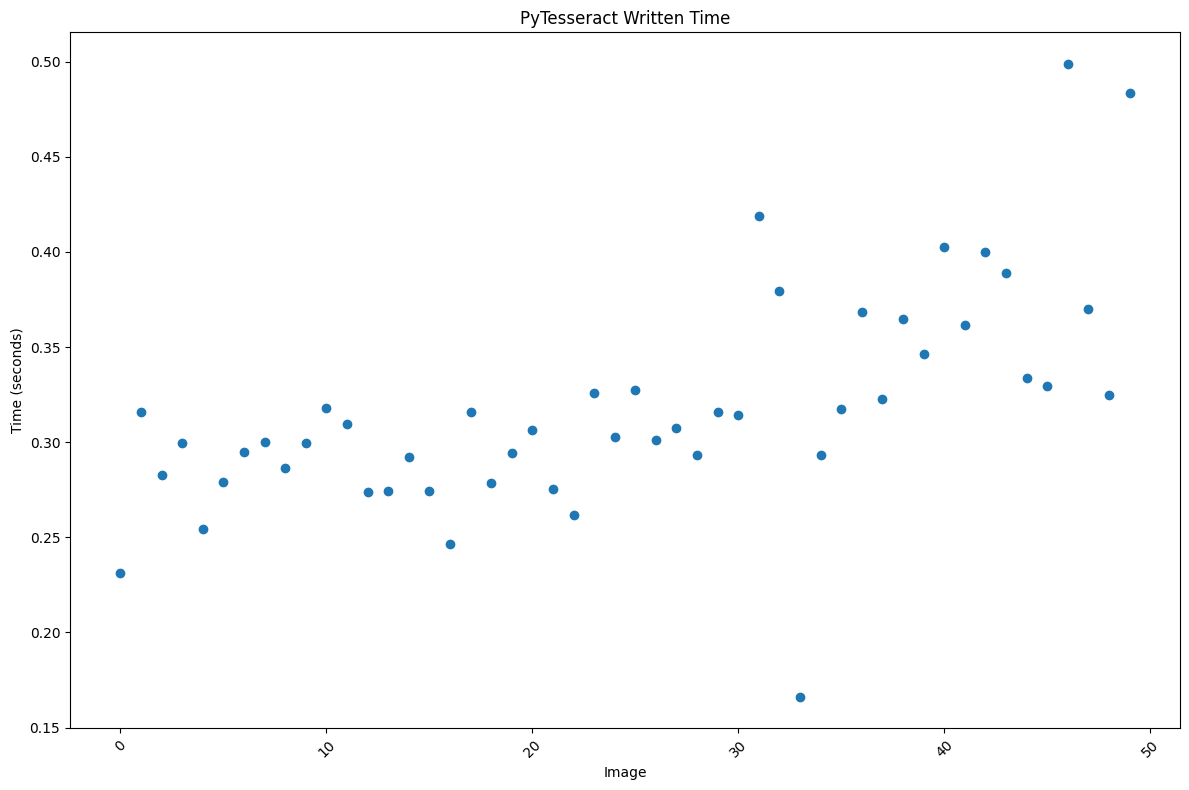

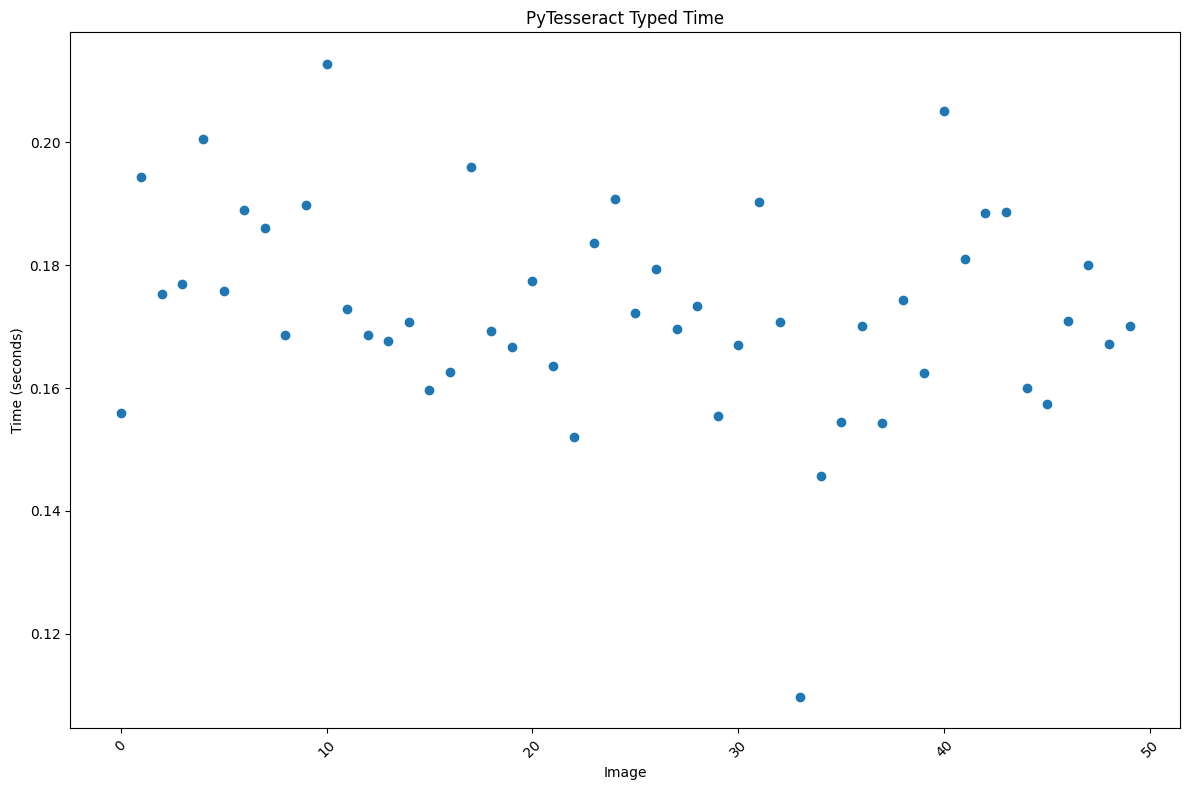

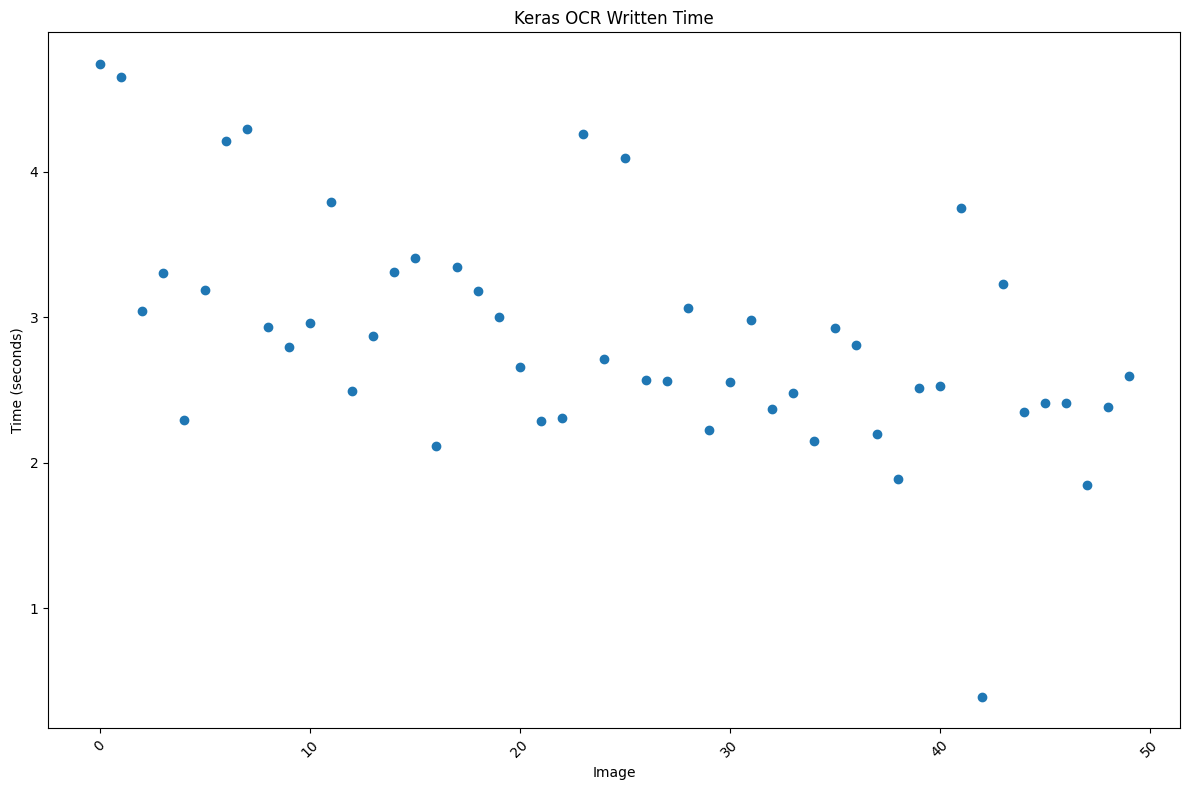

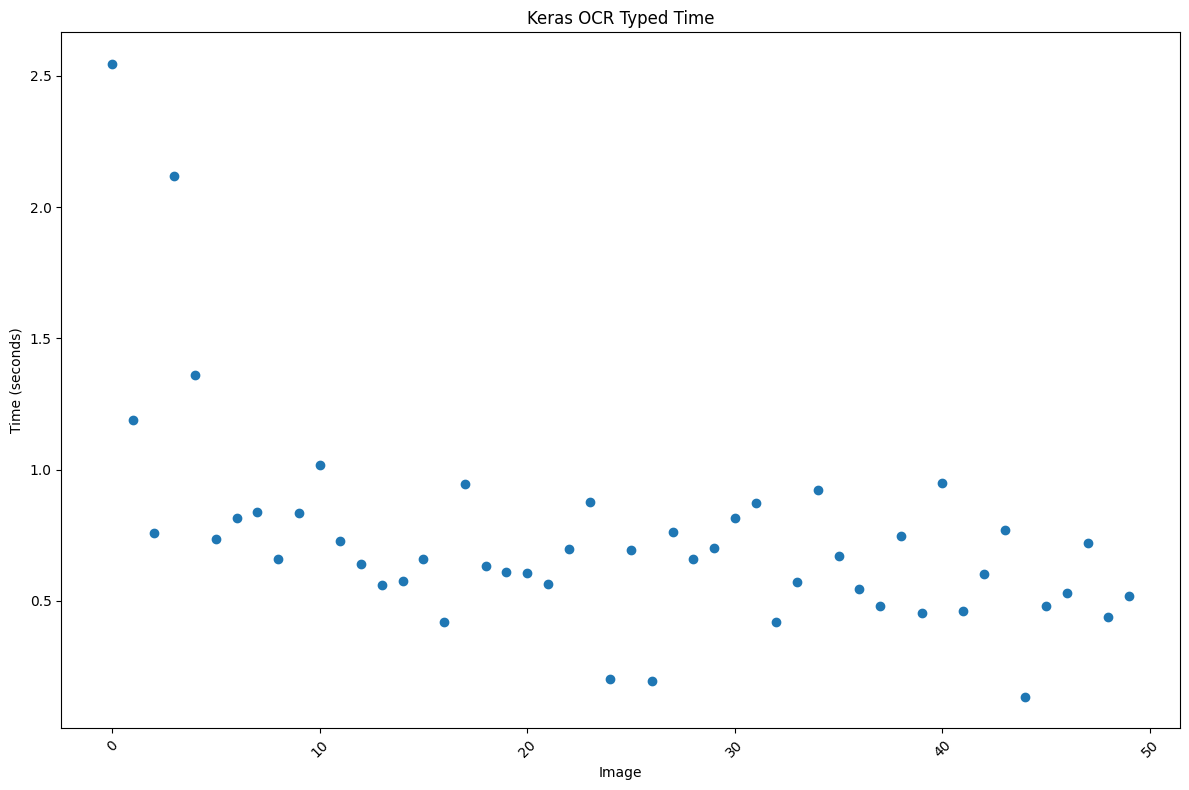

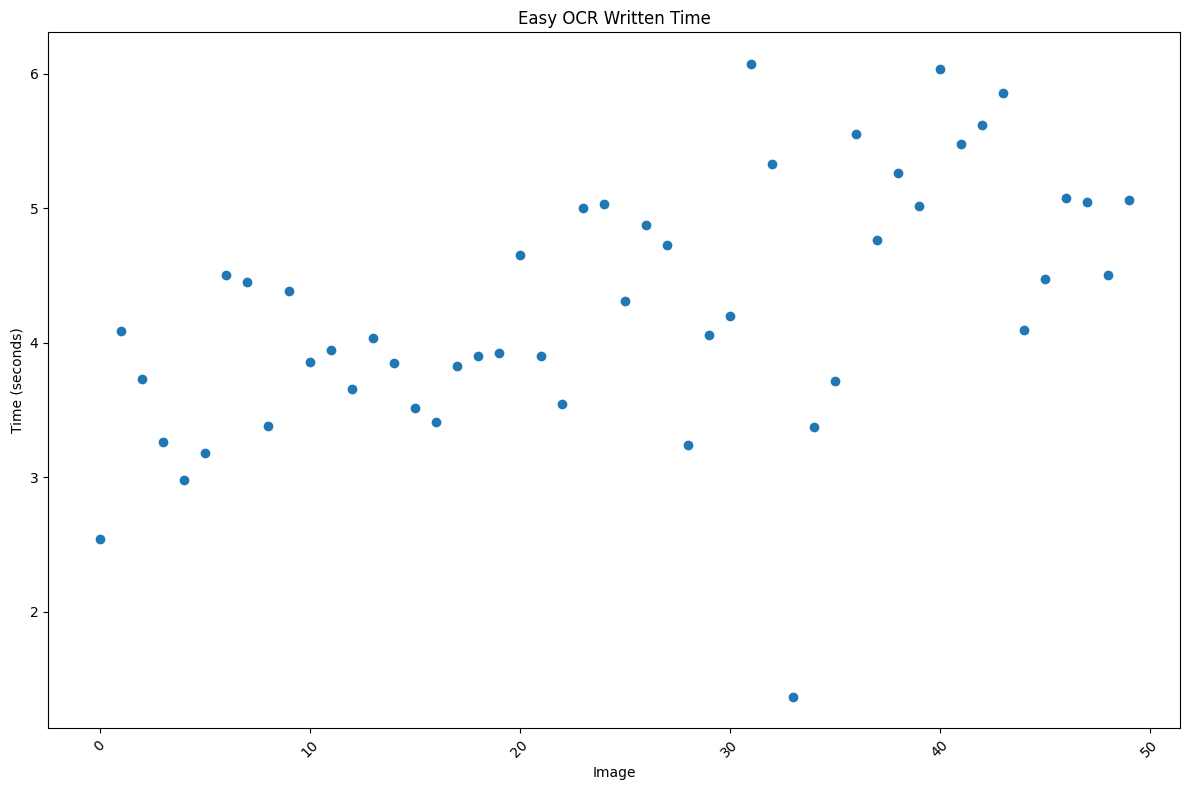

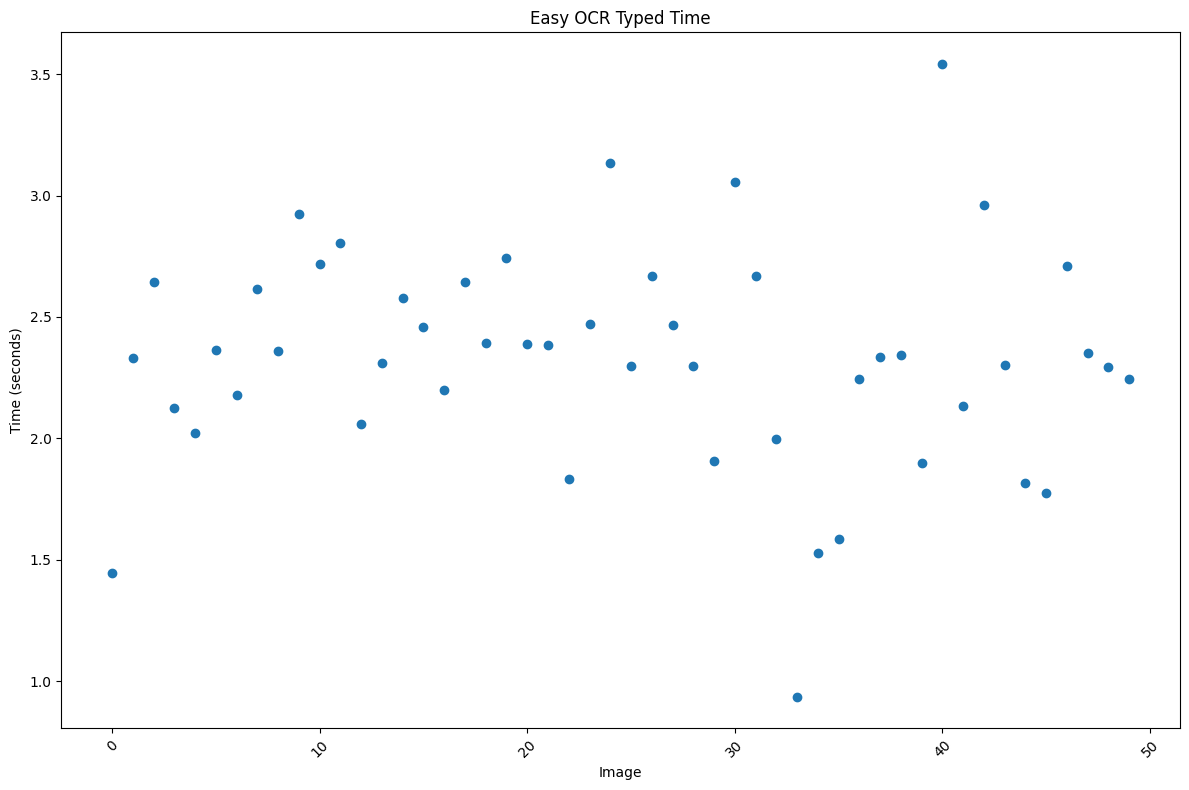

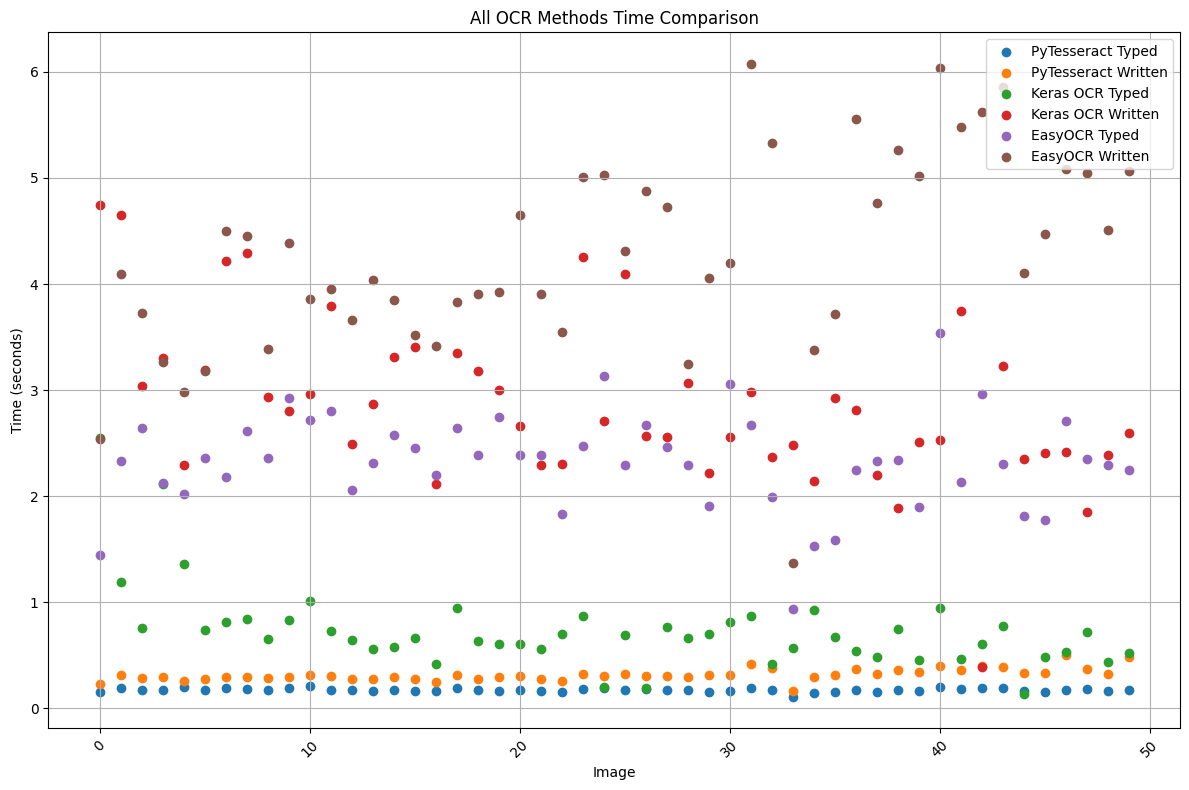

In [96]:
def plotTimes(times_dict, title):
    indices = range(len(times_dict))
    values = list(times_dict.values())
    plt.figure(figsize=(12, 8))
    plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plotAllTimes(lists, legend):
    plt.figure(figsize=(12, 8))
    for times_dict in lists:
        indices = range(len(times_dict))
        values = list(times_dict.values())
        plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title("All OCR Methods Time Comparison")
    plt.legend(legend, loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Uncomment to plot times for each method
# NOTE: Code below will be different than what is used in the report since it was run since the image was included

# Code to plot times for each method
plotTimes(paragraphPyTesseractWrittenTime, "PyTesseract Written Time")
plotTimes(paragraphPyTesseractTypedTime, "PyTesseract Typed Time")
plotTimes(paragraphKerasWrittenTime, "Keras OCR Written Time")
plotTimes(paragraphKerasTypedTime, "Keras OCR Typed Time")
plotTimes(paragraphEasyWrittenTime, "Easy OCR Written Time")
plotTimes(paragraphEasyTypedTime, "Easy OCR Typed Time")

time_dicts = [paragraphPyTesseractTypedTime, paragraphPyTesseractWrittenTime, 
              paragraphKerasTypedTime, paragraphKerasWrittenTime,
              paragraphEasyTypedTime, paragraphEasyWrittenTime]

titles = ['PyTesseract Typed', 'PyTesseract Written',
          'Keras OCR Typed', 'Keras OCR Written',
          'EasyOCR Typed', 'EasyOCR Written']

plotAllTimes(time_dicts, titles)

# Creating Bounding Box Around Text
### For Testing and Investigation

[(11, 17), (93, 17), (93, 31), (11, 31)]


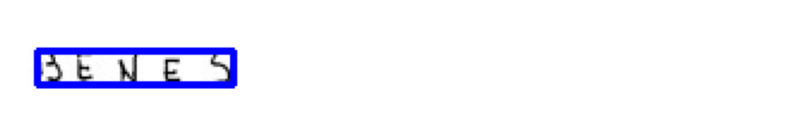

(44, 324, 3)


In [97]:
def getBoundingBox(image_path):
    image = cv2.imread(image_path)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get word-level bounding boxes
    data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

    allBox = []
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0

    # Loop through detected words
    for i in range(len(data['text'])):
        if data['text'][i].strip():  # Ignore empty text
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            
            # Compute full bounding box limits
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x + w)
            y_max = max(y_max, y + h)

            # Store individual word bounding box
            #temp = [(x, y), (x + w, y), (x + w, y + h), (x, y + h)]
            #allBox.append(temp)

            # Draw individual word bounding box
            #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            #cv2.putText(image, data['text'][i], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
    #Use whole image to avoid inf (data already cleaned)
    if x_min == float('inf') or y_min == float('inf'):
        #print("No text detected! Using full image as bounding box.")
        x_min, y_min = 0, 0
        y_max, x_max = image.shape[:2]  # height, width
    full_bbox = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
    
    # Draw single full bounding box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)

    return image, allBox, full_bbox


image, boxes, full_bbox= getBoundingBox("1/train_v2/train/TRAIN_00003.jpg")
print(full_bbox)
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")  # Hide axes
plt.show()
print(image.shape)

Looking for C:\Users\offic\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\offic\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 1s 827ms/step
[(10, 17), (146, 17), (146, 33), (10, 33)]


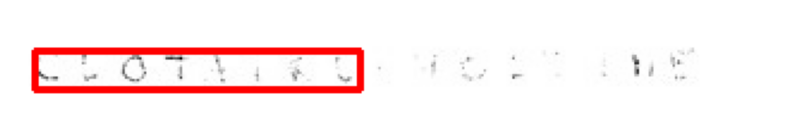

(44, 324, 3)


In [98]:
def getBoundingBox_KerasOCR(image_path):
    image = cv2.imread(image_path)
    
    # Convert to RGB since keras-ocr expects RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    pipeline = keras_ocr.pipeline.Pipeline()
    
    # Word bounding boxes
    predictions = pipeline.recognize([rgb_image])[0]
    
    allBox = []
    x_min, y_min, x_max, y_max = float('inf'), float('inf'), 0, 0
    
    for text, box in predictions:
        # Bbox is array of shape (4, 2) for the 4 corners
        box_points = box.astype(np.int32)
        
        # Store individual word bounding box
        allBox.append(box_points.tolist())
        
        # Update the full bounding box limits
        for point in box_points:
            x, y = point
            x_min = min(x_min, x)
            y_min = min(y_min, y)
            x_max = max(x_max, x)
            y_max = max(y_max, y)
        
        # Draw individual word bounding box
        # cv2.polylines(image, [box_points], True, (0, 255, 0), 2)
        # cv2.putText(image, text, tuple(box_points[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    # Use whole image if no text is detected
    if x_min == float('inf') or y_min == float('inf'):
        x_min, y_min = 0, 0
        y_max, x_max = image.shape[:2]  # height, width
    
    full_bbox = [(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)]
    
    # Draw box
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)
    
    return image, allBox, full_bbox

image, boxes, full_bbox = getBoundingBox_KerasOCR("1/test_v2/test/TEST_0002.jpg")
print(full_bbox)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Back to RGB for displaying
plt.axis("off")  
plt.show()
print(image.shape)

# Training Keras Model

In [99]:
def get_dataset_from_df(df, image_folder, limit):
    dataset = []
    i = 0

    for _, row in df.iterrows():
        if limit == i :
            break
        image_name = row['FILENAME']  # Assuming the column is named 'filename'
        text = row['IDENTITY']  # Assuming the column is named 'text'
        
        # Construct the full image path
        image_path = image_folder+"/"+ image_name
        print(image_path)
        img, allBBox, BBox = getBoundingBox(image_path)
        dataset.append((image_path, {"lines": [{"text": text, "vertices": BBox}]}))
        i += 1

    return dataset
# Create datasets from DataFrames
train_dataset = get_dataset_from_df(train, '1/train_v2/train', 2)
val_dataset = get_dataset_from_df(valid, '1/validation_v2/validation', 1)
test_dataset = get_dataset_from_df(test, '1/test_v2/test', 1)

1/train_v2/train/TRAIN_00001.jpg
1/train_v2/train/TRAIN_00002.jpg
1/validation_v2/validation/VALIDATION_0001.jpg
1/test_v2/test/TEST_0001.jpg


In [100]:
print(train_dataset)
print(val_dataset)
print(test_dataset)

[('1/train_v2/train/TRAIN_00001.jpg', {'lines': [{'text': 'BALTHAZAR', 'vertices': [(30, 10), (163, 10), (163, 43), (30, 43)]}]}), ('1/train_v2/train/TRAIN_00002.jpg', {'lines': [{'text': 'SIMON', 'vertices': [(30, 5), (104, 5), (104, 56), (30, 56)]}]})]
[('1/validation_v2/validation/VALIDATION_0001.jpg', {'lines': [{'text': 'BILEL', 'vertices': [(22, 7), (94, 7), (94, 22), (22, 22)]}]})]
[('1/test_v2/test/TEST_0001.jpg', {'lines': [{'text': 'KEVIN', 'vertices': [(25, 6), (91, 6), (91, 22), (25, 22)]}]})]


In [101]:
def create_keras_ocr_dataset(image_dir, df, limit, image_col='FILENAME', text_col='IDENTITY'):
    dataset = []
    count = 0
    for _, row in df.iterrows():
        if count == limit:
            break
        image_path = image_dir+"/"+ row[image_col]
        if os.path.exists(image_path):
            dataset.append((image_path, row[text_col]))
        else:
            print(f"Warning: Image not found at {image_path}")
        count +=1
    return dataset

train_dataset = create_keras_ocr_dataset( '1/train_v2/train',train, 40000)
validation_dataset = create_keras_ocr_dataset( '1/validation_v2/validation',valid, 8000)
test_datasset = create_keras_ocr_dataset('1/test_v2/test', test, 8000)
print(test_datasset)

[('1/test_v2/test/TEST_0001.jpg', 'KEVIN'), ('1/test_v2/test/TEST_0002.jpg', 'CLOTAIRE'), ('1/test_v2/test/TEST_0003.jpg', 'LENA'), ('1/test_v2/test/TEST_0004.jpg', 'JULES'), ('1/test_v2/test/TEST_0005.jpg', 'CHERPIN'), ('1/test_v2/test/TEST_0006.jpg', 'MARTIN'), ('1/test_v2/test/TEST_0007.jpg', 'VALENTINE'), ('1/test_v2/test/TEST_0008.jpg', 'LORAS'), ('1/test_v2/test/TEST_0009.jpg', 'THIBAULT'), ('1/test_v2/test/TEST_0010.jpg', 'AZABI'), ('1/test_v2/test/TEST_0011.jpg', 'GORTCHAKOFF'), ('1/test_v2/test/TEST_0012.jpg', 'MAHENTHIRAN'), ('1/test_v2/test/TEST_0013.jpg', 'FRANSOISSISEPH'), ('1/test_v2/test/TEST_0014.jpg', 'JEANNE'), ('1/test_v2/test/TEST_0015.jpg', 'DEBORAH'), ('1/test_v2/test/TEST_0016.jpg', 'DROUCS'), ('1/test_v2/test/TEST_0017.jpg', 'JADE'), ('1/test_v2/test/TEST_0018.jpg', 'CORNIL FRERROT'), ('1/test_v2/test/TEST_0019.jpg', 'CLEMET'), ('1/test_v2/test/TEST_0020.jpg', 'RELIS'), ('1/test_v2/test/TEST_0021.jpg', 'NAMIZATA FATIM'), ('1/test_v2/test/TEST_0022.jpg', 'FOURNEL

In [102]:
pipeline = keras_ocr.pipeline.Pipeline()

model = pipeline.recognizer.model

# CTC loss function
def ctc_loss_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# Create the CTC model
def create_ctc_model(base_model, input_shape):
    # Input for images
    input_img = Input(shape=input_shape, name='input_data')

    # Inputs CTC loss
    labels = Input(name='labels', shape=[None], dtype='int32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')
    
    # Output from the base model (going to be recognizer model)
    base_output = base_model(input_img)
    
    # Lambda layer for CTC loss
    loss_out = Lambda(ctc_loss_lambda_func, output_shape=(1,), name='ctc')(
        [base_output, labels, input_length, label_length]
    )
    
    # Create the full model
    model = Model(
        inputs=[input_img, labels, input_length, label_length],
        outputs=loss_out
    )
    return model

# text to integer sequences
def textToNum(texts):
    tokenizer = Tokenizer(char_level=True)  # Character-level encoding
    tokenizer.fit_on_texts(texts)
    texts_encoded = tokenizer.texts_to_sequences(texts)
    texts_encoded = pad_sequences(texts_encoded, maxlen=48, padding='post')

    return texts_encoded

# Prepare data for CTC loss
def prepare_data_for_ctc(images, texts_encoded):
    feature_map_shape = model.output_shape
    sequence_length = feature_map_shape[1]  # The width of the feature map after downsampling

    # Input length = sequence length
    input_length = np.ones((len(images), 1)) * sequence_length

    # Label length is  actual length of each label (ignore padding)
    label_length = np.array([[len(text[text > 0])] for text in texts_encoded])

    return {
        'input_data': images,
        'labels': texts_encoded,
        'input_length': input_length,
        'label_length': label_length
    }

def augment_image(image):
    #angle = random.uniform(-10, 10) Used to fix faded text
    angle = random.uniform(-5, 5)
    h, w = image.shape[:2]
    
    rotation_matrix = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    image = cv2.warpAffine(image, rotation_matrix, (w, h))

    #was used to fix faded text but resulted in too lower accuracy
    #if random.random() > 0.5:
     #   alpha = random.uniform(0.8, 1.2)  # Contrast
     #   beta = random.uniform(-0.1, 0.1)  # Brightness
     #   image = np.clip(alpha * image + beta, 0, 1)

    # Random noise
    if random.random() > 0.5: #tried differetn values for faded text too
        noise = np.random.normal(0, 0.05, image.shape)
        image = np.clip(image + noise, 0, 1)

    return image

def loadTrainData(dataSetList, imageSize=(200, 31), augment=False):
    images = []
    texts = []
    for (path, text) in dataSetList:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, imageSize) / 255.0  # Normalize

        if augment:
            img = augment_image(img)  # Apply augmentation

        images.append(img)
        texts.append(text)
    return np.array(images), texts


#IMAGE PROCESSING HERE
# Load data
imagesTrain, textsTrain = loadTrainData(train_dataset, augment=True)
imagesVal, textVal = loadTrainData(validation_dataset)

imagesTrain = np.expand_dims(imagesTrain, axis=-1)  # Add channel dimension (since not showing and are grayscaled)
imagesVal = np.expand_dims(imagesVal, axis=-1)

# Debugging: Print shapes to verify
print(f"Shape of imagesTrain: {imagesTrain.shape}")  # Should be (num_samples, height, width, 1)
print(f"Shape of imagesVal: {imagesVal.shape}")

# Prep data
textsTrain_encoded = textToNum(textsTrain)
textVal_encoded = textToNum(textVal)

train_inputs = prepare_data_for_ctc(imagesTrain, textsTrain_encoded)
val_inputs = prepare_data_for_ctc(imagesVal, textVal_encoded)

# Dummy outputs for CTC loss
train_outputs = np.zeros((len(imagesTrain), 1))
val_outputs = np.zeros((len(imagesVal), 1))

print(f"Shape of train_inputs: {type(imagesTrain)}")  

Looking for C:\Users\offic\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\offic\.keras-ocr\crnn_kurapan.h5
Shape of imagesTrain: (40000, 31, 200, 1)
Shape of imagesVal: (8000, 31, 200, 1)
Shape of train_inputs: <class 'numpy.ndarray'>


In [ ]:
# Commented out to avoid re-running model

# Create the custom CTC model
input_shape = (imagesTrain.shape[1], imagesTrain.shape[2], imagesTrain.shape[3])  # height, width, channels
model.layers[-1].activation = tf.keras.activations.softmax  #last layer has softmax activation
ctc_model = create_ctc_model(model, input_shape)

# Compile the model with a dummy loss
ctc_model.compile(optimizer=Adam(learning_rate=0.00001), loss={'ctc': lambda y_true, y_pred: y_pred})

# Train the model
from tensorflow.keras.callbacks import ReduceLROnPlateau

#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

newModel = ctc_model.fit(
    x=[train_inputs['input_data'], train_inputs['labels'], train_inputs['input_length'], train_inputs['label_length']],
    y=train_outputs,
    validation_data=(
        [val_inputs['input_data'], val_inputs['labels'], val_inputs['input_length'], val_inputs['label_length']],
        val_outputs
    ),
    epochs=20,
    batch_size=64,
    shuffle=True,
    callbacks=[reduce_lr]
)
'''
Overall, the best model trained was version 2.  Everything after that was implemented to attempt to increase our recognition accuracy.
In this current version, our model would have been improved by adding "EarlyStopping" to prevent the model from overfitting too much
'''

# Save the trained model
#changed latest version to v7 incase accidentally overwrote previous version
ctc_model.save('kerasTrained_v7.h5')

'''
#v2 was the best model trained, without dealing with faded text with accuracy of around 85%
v6 was the model used to deal with faded text, but accuracy dropped to around 83%
Saved models v2 and v6 could be found in the google drive due to the size of the model and github not allowing it to be uploaded
'''

Epoch 1/20
625/625 [==============================] - 140s 218ms/step - loss: 25.6495 - val_loss: 20.6328 - lr: 1.0000e-05
Epoch 2/20
625/625 [==============================] - 143s 228ms/step - loss: 20.1318 - val_loss: 18.5962 - lr: 1.0000e-05
Epoch 3/20
625/625 [==============================] - 139s 223ms/step - loss: 15.1296 - val_loss: 11.0161 - lr: 1.0000e-05
Epoch 4/20
625/625 [==============================] - 137s 220ms/step - loss: 8.9781 - val_loss: 8.5270 - lr: 1.0000e-05
Epoch 5/20
625/625 [==============================] - 146s 233ms/step - loss: 6.6143 - val_loss: 7.5833 - lr: 1.0000e-05
Epoch 6/20
625/625 [==============================] - 126s 201ms/step - loss: 5.4465 - val_loss: 7.1893 - lr: 1.0000e-05
Epoch 7/20
625/625 [==============================] - 167s 268ms/step - loss: 4.7120 - val_loss: 6.9057 - lr: 1.0000e-05
Epoch 8/20
625/625 [==============================] - 164s 262ms/step - loss: 4.1726 - val_loss: 6.7769 - lr: 1.0000e-05
Epoch 9/20
625/625 [======

In [ ]:
ctc_model.summary()

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 31, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 model_35 (Functional)          (None, 48, 37)       8794267     ['input_data[0][0]']             
                                                                                                  
 labels (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 input_length (InputLayer)      [(None, 1)]          0           []                        

# Initialize New Base Model and Load Model

In [103]:
base_model = pipeline.recognizer.model
input_shape = (imagesTrain.shape[1], imagesTrain.shape[2], imagesTrain.shape[3])
ctc_model = create_ctc_model(base_model, input_shape)

#laods best model (v2)
ctc_model.load_weights('kerasTrained_v2.h5')

In [104]:
imagesTest, testText = loadTrainData(test_datasset)
imagesTest = np.expand_dims(imagesTest, axis=-1)

In [105]:
# Define the tokenizer globally
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(textsTrain)  # Fit on training texts

# Encode texts
textsTrain_encoded = tokenizer.texts_to_sequences(textsTrain)
textsTrain_encoded = pad_sequences(textsTrain_encoded, maxlen=48, padding='post')

textVal_encoded = tokenizer.texts_to_sequences(textVal)
textVal_encoded = pad_sequences(textVal_encoded, maxlen=48, padding='post')

In [106]:
prediction = model.predict(imagesTest)
predicted_class = np.argmax(prediction, axis=-1)

# Decode the predicted sequences into text
decoded_text = tokenizer.sequences_to_texts(predicted_class)
print(f"Predicted text: {decoded_text}")

lev_distances = []

for i, (pred, true) in enumerate(zip(decoded_text, testText)):
    pred = removeSpace(pred) #post processing from model
    true = true.lower() #post processing from model
    distance = calculate_similarity_lev(pred, true)

    print(f"Test Sample {i+1}:")
    print(f"  Accuracy: {distance}%")
    print("-" * 30)
    lev_distances.append(distance)

avg_distance = sum(lev_distances) / len(lev_distances)
print(f"Average Accuracy: {avg_distance:.2f}%")

250/250 [==============================] - 10s 36ms/step
Predicted text: ['k e v i n', 'c l o t', 'l e e n a', 'j u u l e s', 'c c h e r r p i i n', 'm a r t i n n', 'v a a l e n n t i n e', 'l o r r a s', 't h i b a u l l t', 'a z a d i', 'g o r t c c h a k o f e', 'm a h e n t h i r r a n n', 'f r a a n e o s s s s e e c a', 'j e a a n n e e', 'd e b o r a h', 'p r o u e s', 'j o e', 'c o r n i l   f r e r r o t', 'c l e m e e n t', 'a e l i i s', 'n a m i z a t a   f a a t i m', 'f o o u r n e l', 'd i c i n n t i o   i l l e s s c a', 'b a r d o t', 'd k v a l', 'a a n t o n y', 'l i s s a', 'c e l i n', 'g r o d z z k i', 'm u g g o', 'h u g o', 'e l o u e n', 's c h h o e h a e c k k e r', 'h o a r a u', 's t e e n k e e r s f', 'd i - f o o n z o', 'b u i r e y', 'r o n a n', 'm i i l l e', 'c a r o l i n e e', 'p a u u l', 'b e c c h r r a a', 'd i b o s', 'j j e a n   c o m e', 'd r e r i n', 'c l o v i i s', 'j j o r i s', 'n a r d i n i', 'c l a i r r e', 'r a f f r r t t', 

In [107]:
def loadDataSingle(groundTruthDf, predictedDir):
    count = 0
    predicted = 0
    print(len(groundTruthDf))

    for file in os.listdir(predictedDir):
        if file.endswith('.txt'):
            slicedFilename = file[:-4]
            filename = slicedFilename + ".jpg"

            # Fetch ground truth data
            # Fetch ground truth data
            groundTruthRow = groundTruthDf.loc[groundTruthDf['FILENAME'] == filename]
            
            if groundTruthRow.empty:
                print(f"[!] No ground truth found for {filename}")
                continue
            
            groundTruth = groundTruthRow['IDENTITY'].values[0].lower()
        
            groundTruth = groundTruthRow['IDENTITY'].values[0].lower()

            predictedPath = os.path.join(predictedDir, file)  # Corrected file path
            
            # Read file contents
            predictedText = openCalculate(predictedPath).strip()

            if not predictedText:
                print(f"Warning: No predicted text found for {filename}")
                continue

            # Calculate similarities
            predictedScoreLev = calculate_similarity_lev(predictedText, groundTruth)
            print(f"File: {filename}")
            print(f"Similarity Percentage from Levenshtein: {predictedScoreLev:.2f}%")
            print("--------------------------------------")
            
            # Accumulate scores
            count += 1
            predicted += predictedScoreLev

    if count > 0:
        return predicted / count
    return None


In [108]:
accuracyKerasPretrain = loadDataSingle(test, 'output-name/keras/')

41289
Predicted: kev iv
Actual: kevin
File: TEST_0001.jpg
Similarity Percentage from Levenshtein: 66.67%
--------------------------------------
Predicted: cl cas
Actual: clotaire
File: TEST_0002.jpg
Similarity Percentage from Levenshtein: 37.50%
--------------------------------------
Predicted: lena
Actual: lena
File: TEST_0003.jpg
Similarity Percentage from Levenshtein: 100.00%
--------------------------------------
Predicted: svies
Actual: jules
File: TEST_0004.jpg
Similarity Percentage from Levenshtein: 40.00%
--------------------------------------
Predicted: chebpi n
Actual: cherpin
File: TEST_0005.jpg
Similarity Percentage from Levenshtein: 75.00%
--------------------------------------
Predicted: prenom 5 martin
Actual: martin
File: TEST_0006.jpg
Similarity Percentage from Levenshtein: 40.00%
--------------------------------------
Predicted: valenti ve
Actual: valentine
File: TEST_0007.jpg
Similarity Percentage from Levenshtein: 80.00%
--------------------------------------
Predic

In [109]:
print(f"Comparing Keras OCR Pretrained vs. Dataset Specific Trained:\n------------------------------------------------------------")
print(f"Pretrain Keras: {accuracyKerasPretrain:.2f}%")
print(f"Dataset Specific Trained: {avg_distance:.2f}%")

Comparing Keras OCR Pretrained vs. Dataset Specific Trained:
------------------------------------------------------------
Pretrain Keras: 56.27%
Dataset Specific Trained: 84.66%


Past Idea (didnt work since error function and how text is encoded)

In [ ]:
#import tensorflow as tf
#import os
#
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.utils import to_categorical
#import numpy as np
#
#def textToNum(texts):
#    numberClasses = 37 #from errors of sizes
#
#    # Step 1: Tokenizer (character-level encoding)
#    tokenizer = Tokenizer(char_level=True)  # Character-level encoding
#    tokenizer.fit_on_texts(texts)
#
#    # Step 2: Convert text to integer sequences
#    textsTrain_encoded = tokenizer.texts_to_sequences(texts)
#
#    # Step 3: Pad sequences (if necessary for your model)
#    from tensorflow.keras.preprocessing.sequence import pad_sequences
#    textsTrain_encoded = pad_sequences(textsTrain_encoded, maxlen=48, padding='post')
#
#    # Step 4: One-hot encode if using categorical crossentropy
#    textsTrain_encoded = to_categorical(textsTrain_encoded, num_classes=numberClasses)
#    return textsTrain_encoded
#
#def ctc_loss(y_true, y_pred):
#    return K.ctc_batch_cost(y_true, y_pred, input_length=K.ones_like(y_pred[:, 0, 0]) * K.shape(y_pred)[1], label_length=K.ones_like(y_true[:, 0]) * K.shape(y_true)[1])
#
#
#
#
#imagesTrain, textsTrain =loadTrainData(train_dataset)
#imagesVal, textVal = loadTrainData(validation_dataset)
#imagesTest, testText = loadTrainData(test_dataset)
#
#textVal_encoded = textToNum(textVal)
#textsTrain_encoded = textToNum(textsTrain)
#
#batch_size = 8
#
#
#print(f"Shape of imagesTrain: {imagesTrain.shape}")  # (number_of_samples, height, width, channels)
#print(f"Shape of textsTrain_encoded: {textsTrain_encoded.shape}")  # (number_of_samples, max_sequence_length)
#
#
#print(f"Shape of imagesVal: {imagesVal.shape}")  # (number_of_samples, height, width, channels)
#print(f"Shape of textsVal_encoded: {textVal_encoded.shape}")  # (number_of_samples, max_sequence_length)
#
#
#assert imagesTrain.shape[0] == textsTrain_encoded.shape[0], "Mismatch in number of samples between images and labels"
#assert imagesVal.shape[0] == textVal_encoded.shape[0], "Mismatch in number of validation samples"
#
#
#recognizer = keras_ocr.recognition.Recognizer()
#model = recognizer.model
#
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#
#newModel = model.fit(
#    x=imagesTrain,
#    y = textsTrain_encoded,#I Think
#    validation_data=(imagesVal, textVal_encoded),
#    epochs=10,
#    batch_size=batch_size
#)
#
#model.save('kerasTrained.h5')